In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures 
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1 --quiet
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score
import os
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
data = pd.read_csv("data/personality_dataset.csv")



In [6]:
data.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert


In [7]:
print("Data shape: ",data.shape)
print("Data info:")
print(data.head)
print("\nMissing data:")
print(data.isnull().sum())

numerical_columns = ["Time_spent_Alone","Social_event_attendance","Going_outside","Friends_circle_size","Post_frequency"]
categorical_columns = ["Stage_fear","Drained_after_socializing"]
target_column = "Personality"

Data shape:  (2900, 8)
Data info:
<bound method NDFrame.head of       Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0                  4.0         No                      4.0            6.0   
1                  9.0        Yes                      0.0            0.0   
2                  9.0        Yes                      1.0            2.0   
3                  0.0         No                      6.0            7.0   
4                  3.0         No                      9.0            4.0   
...                ...        ...                      ...            ...   
2895               3.0         No                      7.0            6.0   
2896               3.0         No                      8.0            3.0   
2897               4.0        Yes                      1.0            1.0   
2898              11.0        Yes                      1.0            NaN   
2899               3.0         No                      6.0            6.0   

     Draine

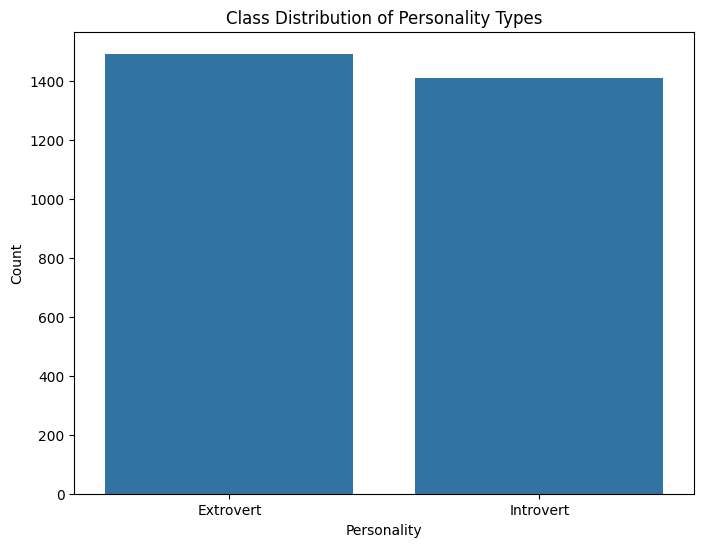

In [8]:

plt.figure(figsize=(8, 6))
sns.countplot(x=target_column, data=data)
plt.title('Class Distribution of Personality Types')
plt.xlabel('Personality')
plt.ylabel('Count')
plt.show()

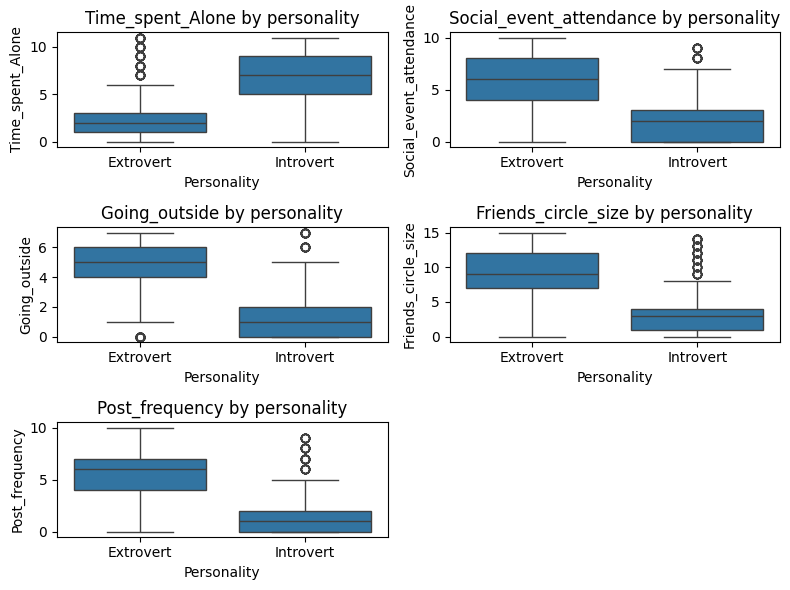

In [9]:
plt.figure(figsize = (8,6))
for i, col in enumerate(numerical_columns,1):
    plt.subplot(3,2,i)
    sns.boxplot(x=target_column,y=col,data=data)
    plt.title(f"{col} by personality")
plt.tight_layout()
plt.show()

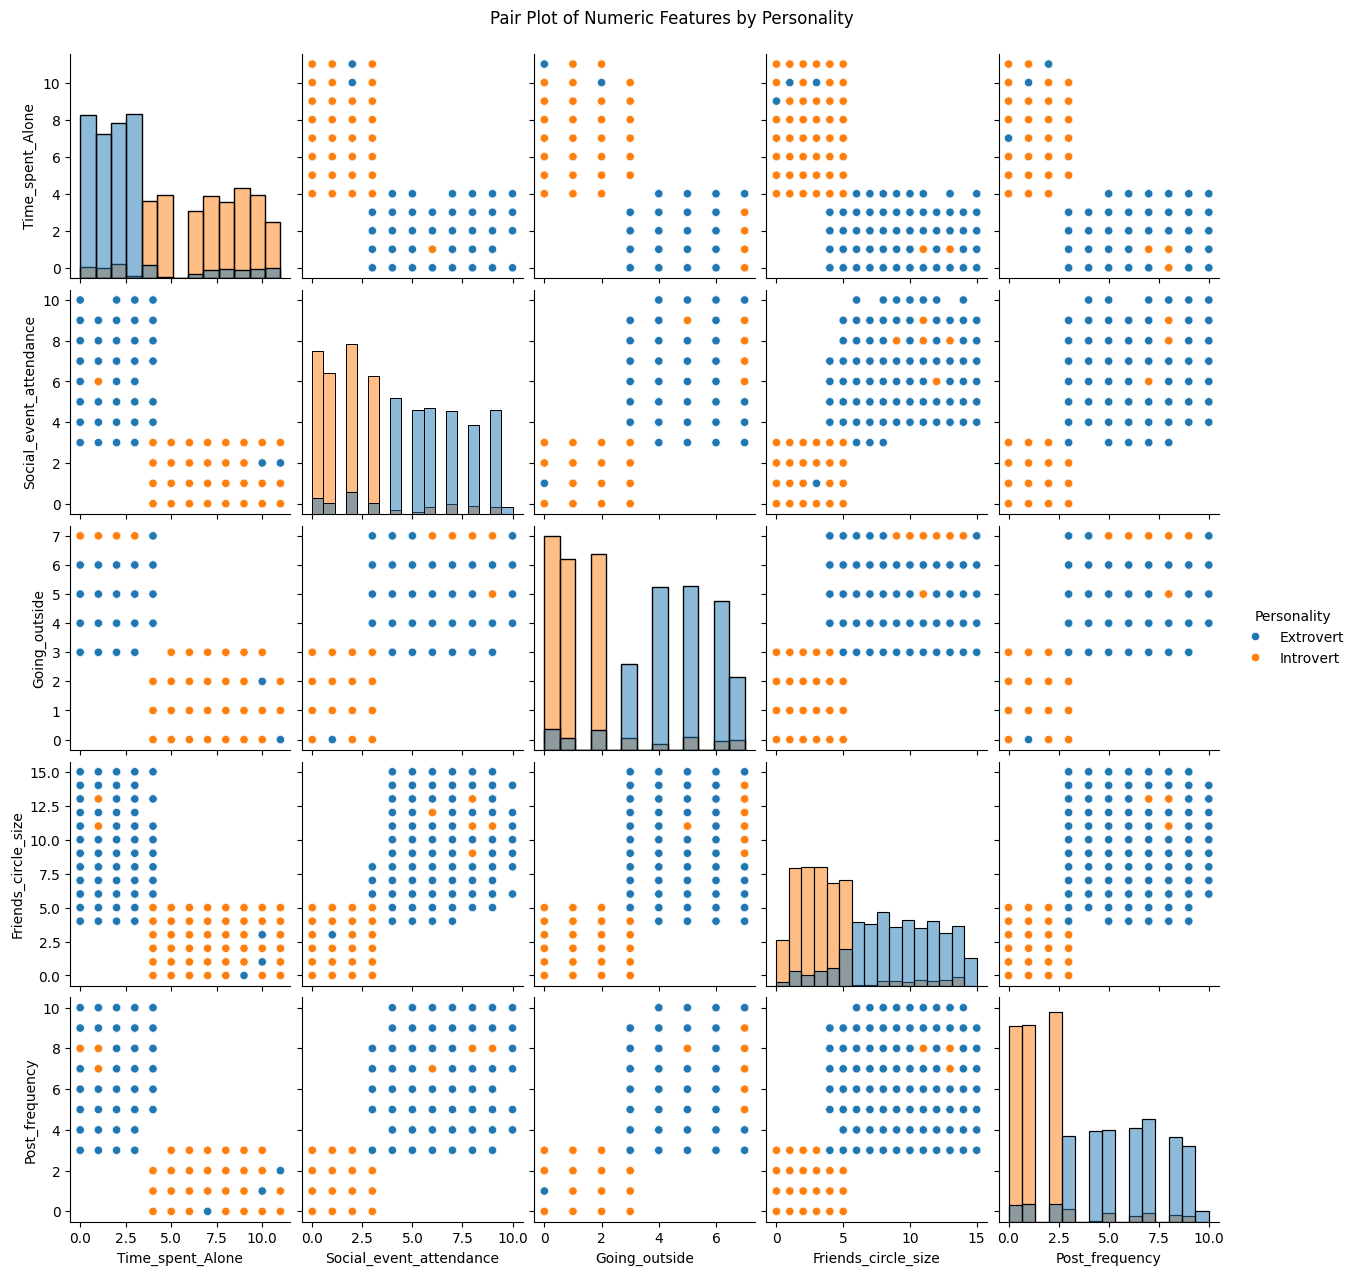

In [10]:
# Pair plot for key features
sns.pairplot(data[numerical_columns + [target_column]], hue=target_column, diag_kind='hist')
plt.suptitle('Pair Plot of Numeric Features by Personality', y=1.02)
plt.show()

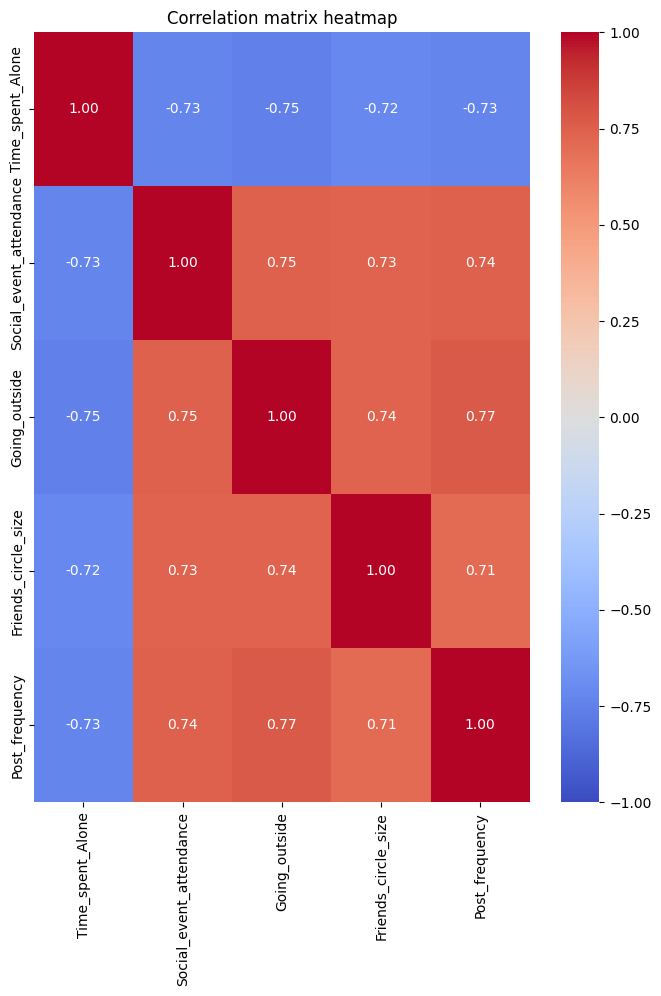

In [11]:
plt.figure(figsize = (8,10))
sns.heatmap(data[numerical_columns].corr(),annot=True,cmap="coolwarm",fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation matrix heatmap")
plt.show()

## Preprocessing the data

In [12]:
le = LabelEncoder()
data[target_column] = le.fit_transform(data[target_column])
print(f"Encoded classes:{dict(zip(le.classes_,le.transform(le.classes_)))}")


# Handling missing values
numeric_imputer = SimpleImputer(strategy="median")
data[numerical_columns] = numeric_imputer.fit_transform(data[numerical_columns])

categorical_imputer = SimpleImputer(strategy="most_frequent")
data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

data = pd.get_dummies(data,columns=categorical_columns,drop_first=True)

encoded_columns = [column for column in data.columns if column !=target_column]

# Now I will handle the outliers without removing them
for col in numerical_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - IQR *1.5
    upper_bound = Q3+IQR * 1.5
    data[col] = data[col].clip(lower=lower_bound,upper=upper_bound)

Encoded classes:{'Extrovert': 0, 'Introvert': 1}


In [13]:
#Train-test split

X = data.drop(columns=[target_column])
y = data[target_column]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

Now I will use SMOTE which aims to balance the class distribution in the dataset.

smote = SMOTE

In [14]:
smote = SMOTE(random_state= 42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [19]:
# Features

X_train = pd.DataFrame(X_train,columns=X.columns)
X_test = pd.DataFrame(X_train,columns=X.columns)

X_train["Alone_to_Social_ration"] = X_train["Time_spent_Alone"] / (X_train['Social_event_attendance'] + 1)
X_test["Alone_to_Social_ration"] = X_test["Time_spent_Alone"] / (X_test['Social_event_attendance'] + 1)
X_train["Social comfort index"] = (X_train["Friends_circle_size"] + X_train['Post_frequency'] - X_train["Stage_fear_Yes"]) / 3
X_test['Social_Comfort_Index'] = (X_test['Friends_circle_size'] + X_test['Post_frequency'] - X_test['Stage_fear_Yes']) / 3
X_train['Social_Overload'] = X_train['Drained_after_socializing_Yes'] * X_train['Social_event_attendance']
X_test['Social_Overload'] = X_test['Drained_after_socializing_Yes'] * X_test['Social_event_attendance']

#Binned features

X_train["Time_spent_Alone_Binned"] = pd.qcut(X_train["Time_spent_Alone"],q=3,labels=['Low','Medium','High'])
X_test['Time_spent_Alone_Binned'] = pd.qcut(X_test['Time_spent_Alone'], q=3, labels=['Low', 'Medium', 'High'])
X_train = pd.get_dummies(X_train,columns=['Time_spent_Alone_Binned'],drop_first=True)
X_test = pd.get_dummies(X_test,columns=['Time_spent_Alone_Binned'],drop_first=True)

#Polynomial features
poly = PolynomialFeatures(degree=2,include_bias=False,interaction_only=True)
poly_features_train = poly.fit_transform(X_train[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
poly_features_test = poly.transform(X_test[['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size']])
poly_feature_names = poly.get_feature_names_out(['Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size'])
X_train[poly_feature_names] = poly_features_train
X_test[poly_feature_names] = poly_features_test

#Update scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
models = {
    'logistic': {
        'model': LogisticRegression(max_iter=1000),
        'use_scaled': True,
        'params': {'C': np.logspace(-4, 4, 20), 'solver': ['lbfgs', 'liblinear']}
    },
    'svm': {
        'model': SVC(probability=True),
        'use_scaled': True,
        'params': {'C': np.logspace(-3, 3, 20), 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto', 0.1, 1]}
    },
    'rf': {
        'model': RandomForestClassifier(random_state=42),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
    },'gb': {
        'model': GradientBoostingClassifier(random_state=42),
        'use_scaled': False,
        'params': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'use_scaled': True,
        'params': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    },
    'dt': {
        'model': DecisionTreeClassifier(random_state=42),
        'use_scaled': False,
        'params': {'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
    },
    'xgb': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'use_scaled': False,
        'params': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'subsample': [0.8]}
    }
}

In [22]:
results = []
for model_name, mp in models.items():
    clf = RandomizedSearchCV(mp['model'], mp['params'], n_iter=20, cv=3, scoring='f1_weighted', n_jobs=-1, random_state=42)
    X_train_current = X_train_scaled if mp['use_scaled'] else X_train
    clf.fit(X_train_current, y_train)
    results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [23]:
# Display model performance
df_results = pd.DataFrame(results)
print("\nModel Performance (Cross-Validation F1-Weighted Scores):")
print(df_results)


Model Performance (Cross-Validation F1-Weighted Scores):
      model  best_score                                        best_params
0  logistic    0.938802    {'solver': 'lbfgs', 'C': 0.0006951927961775605}
1       svm    0.938802  {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.3359...
2        rf    0.938371  {'n_estimators': 100, 'min_samples_split': 5, ...
3        gb    0.937509  {'n_estimators': 300, 'max_depth': 3, 'learnin...
4       knn    0.937940           {'weights': 'uniform', 'n_neighbors': 7}
5        dt    0.933628          {'min_samples_split': 10, 'max_depth': 5}
6       xgb    0.938371  {'subsample': 0.8, 'n_estimators': 150, 'max_d...


In [24]:
# Stacking ensemble
estimators = [
    ('rf', RandomForestClassifier(**df_results.loc[df_results['model'] == 'rf']['best_params'].iloc[0], random_state=42)),
    ('gb', GradientBoostingClassifier(**df_results.loc[df_results['model'] == 'gb']['best_params'].iloc[0], random_state=42)),
    ('xgb', XGBClassifier(**df_results.loc[df_results['model'] == 'xgb']['best_params'].iloc[0], random_state=42, eval_metric='logloss')),
    ('svm', SVC(**df_results.loc[df_results['model'] == 'svm']['best_params'].iloc[0], probability=True))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000), n_jobs=-1)
stacking_model.fit(X_train_scaled, y_train)

# Cross-validation for stacking model
stacking_scores = cross_val_score(stacking_model, X_train_scaled, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
print(f"\nStacking Model Cross-Validation F1-Weighted Score: {stacking_scores.mean():.3f} ± {stacking_scores.std():.3f}")



Stacking Model Cross-Validation F1-Weighted Score: 0.939 ± 0.004


In [25]:
y_pred = stacking_model.predict(X_test_scaled)
print("\nStacking Model Classification Report:")
print(classification_report(y_test,y_pred,target_names=le.classes_))


Stacking Model Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.94      0.90      0.92       298
   Introvert       0.90      0.94      0.92       282

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580



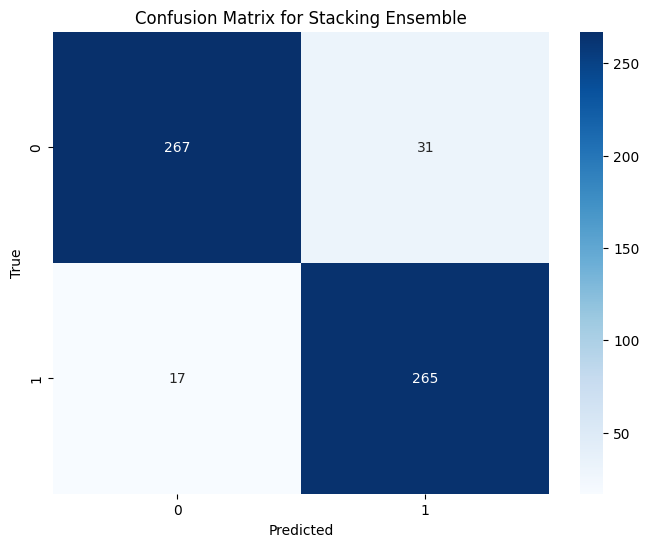

In [28]:
#Consufion matrix

plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d",cmap="Blues")
plt.title('Confusion Matrix for Stacking Ensemble')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

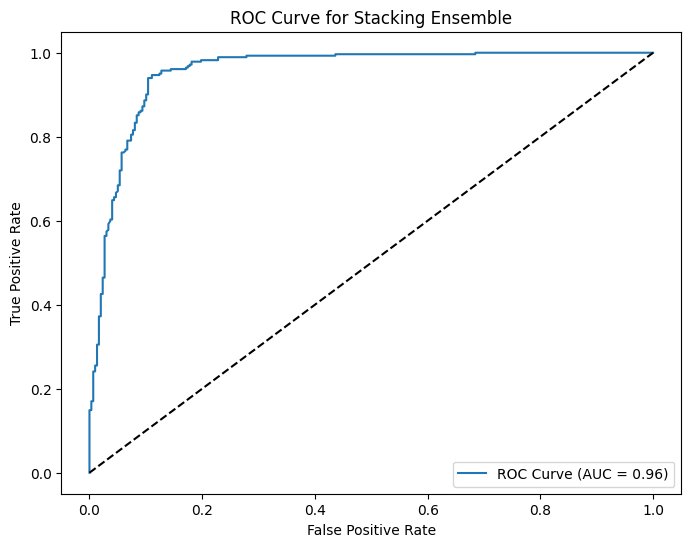

In [29]:
fpr,tpr,_ = roc_curve(y_test,stacking_model.predict_proba(X_test_scaled)[:,1])
roc_auc = roc_auc_score(y_test, stacking_model.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacking Ensemble')
plt.legend()
plt.show()


Feature Importance (Random Forest):
                           Feature  Importance
7           Alone_to_Social_ration    0.261237
8             Social comfort index    0.196499
5                   Stage_fear_Yes    0.146842
1          Social_event_attendance    0.138941
6    Drained_after_socializing_Yes    0.072782
0                 Time_spent_Alone    0.062069
4                   Post_frequency    0.057831
2                    Going_outside    0.040571
3              Friends_circle_size    0.016407
9                  Social_Overload    0.004246
10  Time_spent_Alone_Binned_Medium    0.001777
11    Time_spent_Alone_Binned_High    0.000800


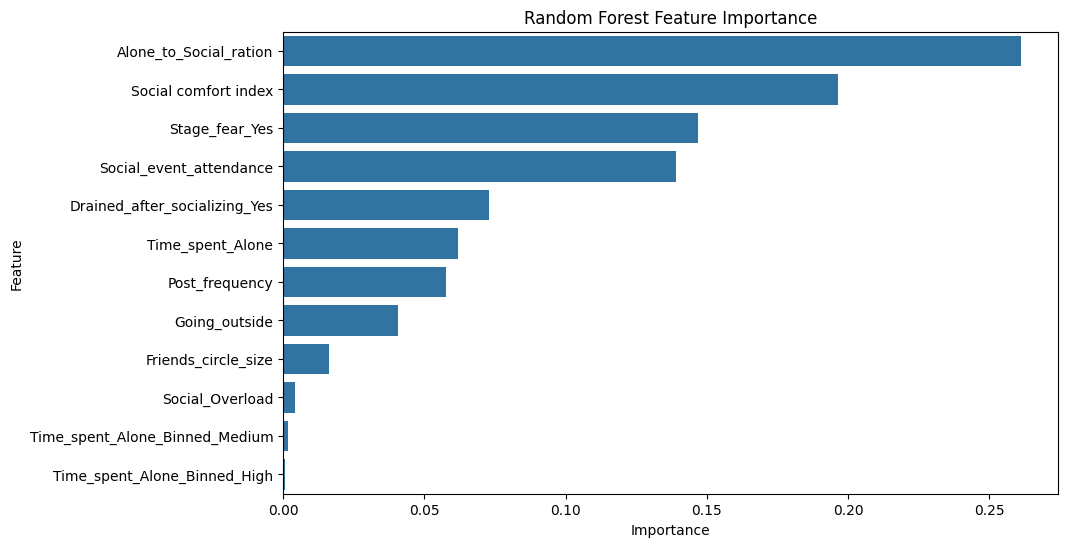

In [34]:
rf_model = RandomForestClassifier(**df_results.loc[df_results['model'] == 'rf']['best_params'].iloc[0], random_state=42)
rf_model.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Random Forest):")
print(feature_importance)

# Feature importance bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()